In [2]:
# coding=utf-8
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

batch_size = 3

# 数据读取
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train = tf.cast(x_train, tf.float32) / 255
x_test = tf.cast(x_test, tf.float32) / 255
train_iter = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
test_iter = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

print('load data done')

# 图像label：共10个类别
# 图像向量维度： 28*28*1

load data done


In [1]:
# 初始化模型参数
num_inputs = 28*28
num_outputs = 10

W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=0.01, dtype=tf.float32))
b = tf.Variable(tf.zeros(shape=(num_outputs),dtype=tf.float32))

# softmax
def softmax(logits, axis=-1):
    '''
    @logits：输入 input=Wx+b (batch_size, num_outputs)
    @axis: -1 表示最后一个dim，就是axis=1
    '''
    return tf.exp(logits)/tf.reduce_sum(tf.exp(logits), axis, keepdims=True)

def check_softmax():
    x = tf.random.normal(shape=(2,5))
    x_prob = softmax(x)
    # print(x_prob)
    # print(tf.reduce_sum(x_prob, axis=1), '\nprob sum should be 1.0')

# 定义模型
with tf.device("CPU:0"):
    def net(x):
        # x*w 维度： batch_size*num_outputs
        logits = tf.matmul(tf.reshape(x, shape=(-1, W.shape[0])), W)
        # 广播机制，b的维度自动补全
        # print(logits.shape, b.shape)
        logits += b
        return softmax(logits)
        # print(logits.shape)

    def cross_entropy(y_hat, y):
        '''
        cross_entropy = -log(yi) 
        i即softmax输出的logits中最大的那个yi
        '''
        # y [batch_size, ] reshape to [batch_size, 1]
        y = tf.cast(tf.reshape(y, shape=(-1,1)), dtype=tf.int32)
                
        # one-hot 表示: y_hat.shape = [batch_size, 10]
        y = tf.one_hot(y, depth=y_hat.shape[-1], axis=1)
        y = tf.cast(y, dtype=tf.int32)
        # 从 [batch_size, 10, 1] reshape 到 [batch_size, 10] 
        y = tf.reshape(y, shape=(-1, y_hat.shape[-1]))
        # 防止log(0) 一定要加上一个小数 1e-5, 但是太小如1e-8会得到inf
        return -tf.math.log(tf.boolean_mask(y_hat, y) + 1e-8)
    
    def accuracy(y_hat, y):
        return np.mean(tf.argmax(y,axis=1) == y)
    
    def evaluate_acc(data_iter, net):
        acc_sum, n = 0.0, 0
        for _, (x, y) in enumerate(data_iter):
            y = tf.cast(y, dtype=tf.int64)
            acc_sum += np.sum(tf.cast(tf.argmax(net(x), axis=1), dtype=tf.int64) == y)
            n += y.shape[0]
        return acc_sum / n

    def train_net(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, trainer=None):
        for epoch in range(num_epochs):
            train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
            for x, y in train_iter:
                with tf.GradientTape() as tape:
                    y_hat = net(x)
                    cross_entropy_value = loss(y_hat, y)
                    # reduce_sum 默认axis=None,keepdims=None,会返回一个数
                    loss_value = tf.reduce_sum(cross_entropy_value)
                grads = tape.gradient(loss_value, params)
                if trainer is None:
                    for i, param in enumerate(params):
                        param.assign_sub(lr * grads[i] / batch_size)
                else:
                    trainer.applay_gradients(zip([grad.batch_size for grad in grads], params))

                # evaluate
                y = tf.cast(y, dtype=tf.float32)
                train_l_sum += loss_value.numpy()
                train_acc_sum += tf.reduce_sum(tf.cast(tf.argmax(y_hat, axis=1) == tf.cast(y, dtype=tf.int64), dtype=tf.int64)).numpy()
                n += y.shape[0]
                
            test_acc = evaluate_acc(test_iter, net)
            print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'%(epoch+1, train_l_sum / n, train_acc_sum/n, test_acc))
            

    lr = 0.01       
    num_epochs = 10
    batch_size = 4
    trainer = tf.keras.optimizers.SGD(lr)
    train_net(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W, b], lr)
    

    


NameError: name 'tf' is not defined

Figure(864x864) [<matplotlib.axes._subplots.AxesSubplot object at 0x00000248F1148F48>


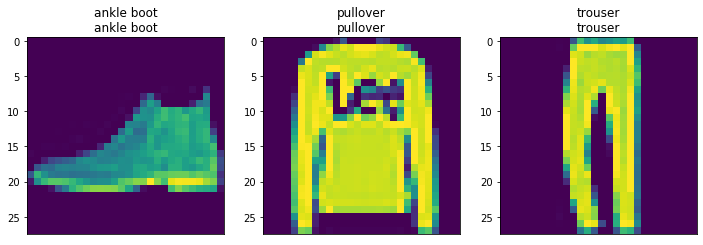

In [52]:
import matplotlib.pyplot as plt

x,y = iter(test_iter).next()

with tf.device('CPU:0'):


    def get_labels(labels):
        text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
        return [text_labels[int(i)] for i in labels]

    def show_fashion_mnist(images, labels):
        _, axes = plt.subplots(1, len(images), figsize=(12, 12))
        print(_, axes)
        for f, img, lbl in zip(axes, images, labels):
            f.imshow(tf.reshape(img, shape=(28,28)).numpy())
            f.set_title(lbl)
            f.get_xaxis().set_visible(False)
            # f.get_yaxis().set_visible(False)
            
        plt.show()

    true_labels = get_labels(y.numpy())
    pred_labels = get_labels(tf.argmax(net(x), axis=1).numpy())
    titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]

    show_fashion_mnist(x[0:9], titles[0:9])